<a href="https://colab.research.google.com/github/Felipepa9/MADSI/blob/main/Secci%C3%B3n_1_MOD_SIST_INT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
!pip install scikit-fuzzy

Traceback (most recent call last):
  File "<frozen importlib._bootstrap>", line 1147, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 690, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 940, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/utils/logging.py", line 29, in <module>
^C


In [4]:
%load_ext autoreload
%reload_ext autoreload
%matplotlib inline

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

sns.set(style="whitegrid")

In [6]:
data = pd.read_csv('/content/drive/MyDrive/MOD. Y SIST. INTELIGENTES/SECCION_1.csv')
data.head()

,taxi_fuel_kg_qty,trip_fuel_kg_qty,reserve_fuel_kg_qty,alternate_fuel_kg_qty,hold_altern_fuel_kg_qty,extra_fuel_kg_qty,RENTABILIDAD
0,800,15450,773,2298,2137,0,0
1,800,14740,737,3032,2060,0,0
2,800,15035,752,2320,2094,0,0
3,800,15240,762,2342,2094,0,0
4,800,16054,803,2330,2116,0,0


In [7]:
# prompt: tome los títulos de las 6 primeras columnas de data y pongalos como una variable feature_names

feature_names = data.columns[:6].tolist()
feature_names


['taxi_fuel_kg_qty',
 'trip_fuel_kg_qty',
 'reserve_fuel_kg_qty',
 'alternate_fuel_kg_qty',
 'hold_altern_fuel_kg_qty',
 'extra_fuel_kg_qty']

In [8]:
data['TIPO_RENTAB'] = data['RENTABILIDAD'].map({
        0: 'alta',
        1: 'media',
        2: 'baja'
    })

data.head()

,taxi_fuel_kg_qty,trip_fuel_kg_qty,reserve_fuel_kg_qty,alternate_fuel_kg_qty,hold_altern_fuel_kg_qty,extra_fuel_kg_qty,RENTABILIDAD,TIPO_RENTAB
0,800,15450,773,2298,2137,0,0,alta
1,800,14740,737,3032,2060,0,0,alta
2,800,15035,752,2320,2094,0,0,alta
3,800,15240,762,2342,2094,0,0,alta
4,800,16054,803,2330,2116,0,0,alta


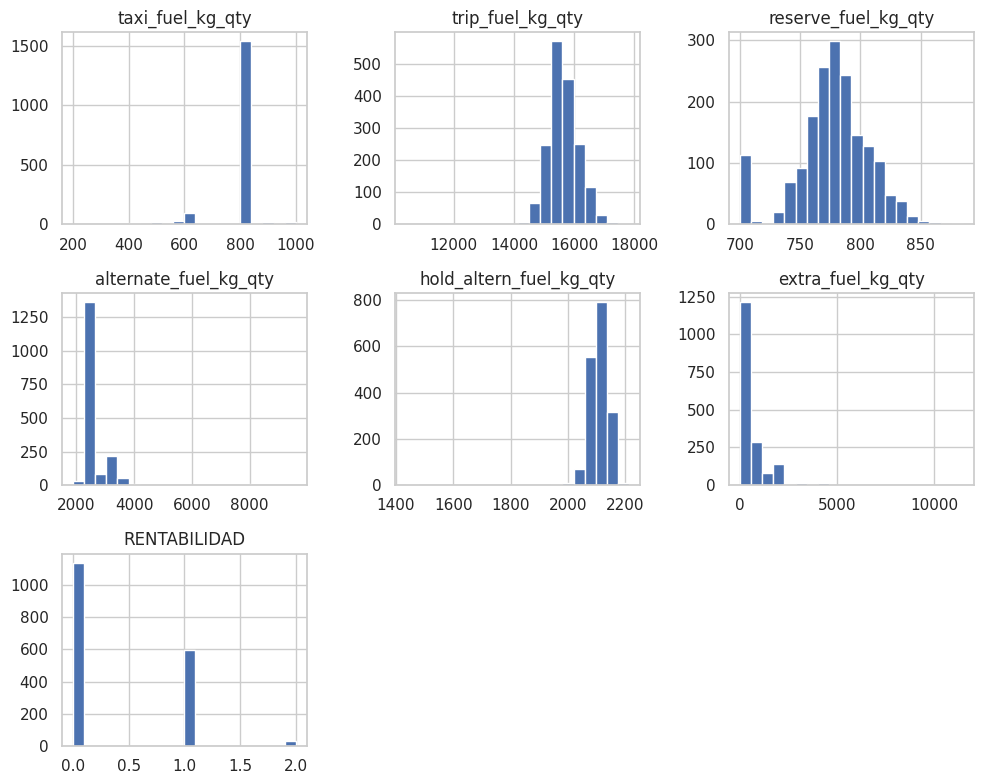

In [9]:
data.hist(bins=20, figsize=(10, 8))
plt.tight_layout()
plt.show()

In [11]:
    #Variables de entrada
    taxi_fuel_kg_qty = ctrl.Antecedent(np.arange(200, 1000, 1), 'taxi_fuel_kg_qty') # Largo del sépalo
    trip_fuel_kg_qty = ctrl.Antecedent(np.arange(10000, 20000, 1), 'trip_fuel_kg_qty')   # Ancho del sépalo
    reserve_fuel_kg_qty = ctrl.Antecedent(np.arange(500, 1000, 1), 'reserve_fuel_kg_qty') # Largo del pétalo
    alternate_fuel_kg_qty = ctrl.Antecedent(np.arange(1000, 10000, 1), 'alternate_fuel_kg_qty')  # Ancho del pétalo
    hold_altern_fuel_kg_qty = ctrl.Antecedent(np.arange(1000, 3000, 1), 'hold_altern_fuel_kg_qty')  # Ancho del pétalo
    extra_fuel_kg_qty = ctrl.Antecedent(np.arange(0, 15000, 1), 'extra_fuel_kg_qty')  # Ancho del pétalo

In [12]:
 #Variable de salida
 TIPO_RENTAB = ctrl.Consequent(np.arange(0, 2.1, 0.1), 'TIPO_RENTAB')

In [13]:
#Funciones de pertenencia
taxi_fuel_kg_qty['ajustado'] = fuzz.trimf(taxi_fuel_kg_qty.universe, [200,500,599])
taxi_fuel_kg_qty['moderado'] = fuzz.trimf(taxi_fuel_kg_qty.universe, [500,600,800])
taxi_fuel_kg_qty['excesivo'] = fuzz.trimf(taxi_fuel_kg_qty.universe, [600,1000,1000])

trip_fuel_kg_qty['ajustado'] = fuzz.trimf(trip_fuel_kg_qty.universe, [10000,16000,16999])
trip_fuel_kg_qty['moderado'] = fuzz.trimf(trip_fuel_kg_qty.universe, [16000,18000,18600])
trip_fuel_kg_qty['excesivo'] = fuzz.trimf(trip_fuel_kg_qty.universe, [18000,20000,20000])

reserve_fuel_kg_qty['ajustado'] = fuzz.trimf(reserve_fuel_kg_qty.universe, [500,600,699])
reserve_fuel_kg_qty['moderado'] = fuzz.trimf(reserve_fuel_kg_qty.universe, [600,700,750])
reserve_fuel_kg_qty['excesivo'] = fuzz.trimf(reserve_fuel_kg_qty.universe, [700,1000,1000])

alternate_fuel_kg_qty['ajustado'] = fuzz.trimf(alternate_fuel_kg_qty.universe, [1000,5000,7000])
alternate_fuel_kg_qty['moderado'] = fuzz.trimf(alternate_fuel_kg_qty.universe, [5000,8000,8500])
alternate_fuel_kg_qty['excesivo'] = fuzz.trimf(alternate_fuel_kg_qty.universe, [8000,10000,10000])

hold_altern_fuel_kg_qty['ajustado'] = fuzz.trimf(hold_altern_fuel_kg_qty.universe, [1000,1500,1500])
hold_altern_fuel_kg_qty['moderado'] = fuzz.trimf(hold_altern_fuel_kg_qty.universe, [1500,2000,2000])
hold_altern_fuel_kg_qty['excesivo'] = fuzz.trimf(hold_altern_fuel_kg_qty.universe, [2000,3000,3000])

extra_fuel_kg_qty['ajustado'] = fuzz.trimf(extra_fuel_kg_qty.universe, [0,200,300])
extra_fuel_kg_qty['moderado'] = fuzz.trimf(extra_fuel_kg_qty.universe, [300,3000,3500])
extra_fuel_kg_qty['excesivo'] = fuzz.trimf(extra_fuel_kg_qty.universe, [3500,15000,15000])

In [7]:
 """
    Crea un sistema de lógica difusa para clasificar orquídeas.

    Args:
        feature_names (list): Lista de nombres de las características.

    Returns:
        ctrl.ControlSystemSimulation: Simulador del sistema fuzzy.
        ['taxi_fuel_kg_qty',
 'trip_fuel_kg_qty',
 'reserve_fuel_kg_qty',
 'alternate_fuel_kg_qty',
 'hold_altern_fuel_kg_qty',
 'extra_fuel_kg_qty']
    """
    print("\nCreando el sistema fuzzy...")

    # Crear las variables de entrada (antecedentes)
    # Los rangos se ajustan según los valores típicos del dataset Iris.
    taxi_fuel_kg_qty = ctrl.Antecedent(np.arange(200, 1000, 1), 'taxi_fuel_kg_qty') # Largo del sépalo
    trip_fuel_kg_qty = ctrl.Antecedent(np.arange(10000, 20000, 1), 'trip_fuel_kg_qty')   # Ancho del sépalo
    reserve_fuel_kg_qty = ctrl.Antecedent(np.arange(500, 1000, 1), 'reserve_fuel_kg_qty') # Largo del pétalo
    alternate_fuel_kg_qty = ctrl.Antecedent(np.arange(1000, 10000, 1), 'alternate_fuel_kg_qty')  # Ancho del pétalo
    hold_altern_fuel_kg_qty = ctrl.Antecedent(np.arange(1000, 3000, 1), 'hold_altern_fuel_kg_qty')  # Ancho del pétalo
    extra_fuel_kg_qty = ctrl.Antecedent(np.arange(0, 15000, 1), 'extra_fuel_kg_qty')  # Ancho del pétalo

    # Crear la variable de salida (consecuente)
    # Representa las clases: 0 (setosa), 1 (versicolor), 2 (virginica)
    species = ctrl.Consequent(np.arange(0, 2.1, 0.1), 'species')

    # Definir las funciones de pertenencia para cada variable de entrada
    # Longitud del sépalo
    sepal_length['corto'] = fuzz.trimf(sepal_length.universe, [4, 4, 5.8])
    sepal_length['medio'] = fuzz.trimf(sepal_length.universe, [5.0, 6.0, 7.0])
    sepal_length['largo'] = fuzz.trimf(sepal_length.universe, [6.0, 8, 8])

    # Ancho del sépalo
    sepal_width['estrecho'] = fuzz.trimf(sepal_width.universe, [2, 2, 3.0])
    sepal_width['medio'] = fuzz.trimf(sepal_width.universe, [2.8, 3.3, 3.8])
    sepal_width['ancho'] = fuzz.trimf(sepal_width.universe, [3.5, 4.5, 4.5])

    # Longitud del pétalo
    petal_length['corto'] = fuzz.trimf(petal_length.universe, [1, 1, 2.5])
    petal_length['medio'] = fuzz.trimf(petal_length.universe, [2, 4, 5.5]) # Ajustado para versicolor/virginica
    petal_length['largo'] = fuzz.trimf(petal_length.universe, [4.5, 7, 7])

    # Ancho del pétalo
    petal_width['estrecho'] = fuzz.trimf(petal_width.universe, [0, 0, 0.8])
    petal_width['medio'] = fuzz.trimf(petal_width.universe, [0.6, 1.3, 2.0]) # Ajustado
    petal_width['ancho'] = fuzz.trimf(petal_width.universe, [1.5, 2.5, 2.5])

    # Definir las funciones de pertenencia para la variable de salida
    # Se usan valores más separados para facilitar la desfusificación a clases discretas
    species['setosa'] = fuzz.trimf(species.universe, [0, 0, 0.5])       # Clase 0
    species['versicolor'] = fuzz.trimf(species.universe, [0.5, 1, 1.5]) # Clase 1
    species['virginica'] = fuzz.trimf(species.universe, [1.5, 2, 2])    # Clase 2


    print("\nVisualizando Funciones de Pertenencia:")
    sepal_length.view()
    plt.title("Funciones de Pertenencia para Longitud del Sépalo")
    plt.show()
    sepal_width.view()
    plt.title("Funciones de Pertenencia para Ancho del Sépalo")
    plt.show()
    petal_length.view()
    plt.title("Funciones de Pertenencia para Longitud del Pétalo")
    plt.show()
    petal_width.view()
    plt.title("Funciones de Pertenencia para Ancho del Pétalo")
    plt.show()
    species.view()
    plt.title("Funciones de Pertenencia para Especie")
    plt.show()

    # Definir las reglas fuzzy
    print("\nDefiniendo las reglas fuzzy...")
    # Reglas ajustadas basadas en características conocidas de las especies Iris
    # Iris Setosa: pétalos cortos y estrechos
    rule1 = ctrl.Rule(
        (petal_length['corto'] & petal_width['estrecho']),
        species['setosa']
    )
    # Iris Versicolor: pétalos y anchos de pétalos medios, longitud de sépalo media
    rule2 = ctrl.Rule(
        (petal_length['medio'] & petal_width['medio']) &
        (sepal_length['medio'] | sepal_length['corto']) & # Puede tener sépalos cortos o medios
        (sepal_width['estrecho'] | sepal_width['medio']),
        species['versicolor']
    )
    # Iris Virginica: pétalos y anchos de pétalos largos, longitud de sépalo larga
    rule3 = ctrl.Rule(
        (petal_length['largo'] & petal_width['ancho']),
        species['virginica']
    )
    # Reglas adicionales para mejorar la clasificación y cubrir más casos
    # Si el pétalo es corto pero el ancho del sépalo es ancho, podría ser setosa
    rule4 = ctrl.Rule(
        petal_length['corto'] & sepal_width['ancho'],
        species['setosa']
    )
    # Si la longitud del pétalo es media y el ancho del pétalo es ancho, tiende a virginica
    rule5 = ctrl.Rule(
        petal_length['medio'] & petal_width['ancho'],
        species['virginica']
    )
    # Si la longitud del pétalo es larga y el ancho del pétalo es medio, también tiende a virginica
    rule6 = ctrl.Rule(
        petal_length['largo'] & petal_width['medio'],
        species['virginica']
    )


    print("\nReglas definidas!")

    # Crear el sistema de control: ASEGÚRATE DE INCLUIR TODAS LAS REGLAS DEFINIDAS
    # El error original podría estar en no incluir todas las reglas aquí
    system = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6])
    simulator = ctrl.ControlSystemSimulation(system)

